<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Продвинутый поток. Весна 2021</b></h3>

Это домашнее задание будет посвящено полноценному решению задачи машинного обучения.

Есть две части этого домашнего задания: 
* Сделать полноценный отчет о вашей работе: как вы обработали данные, какие модели попробовали и какие результаты получились (максимум 10 баллов). За каждую выполненную часть будет начислено определенное количество баллов.
* Лучшее решение отправить в соревнование на [kaggle](https://www.kaggle.com/c/advanced-dls-spring-2021/) (максимум 5 баллов). За прохождение определенного порогов будут начисляться баллы.


**Обе части будут проверяться в формате peer-review. Т.е. вашу посылку на степик будут проверять несколько других студентов и аггрегация их оценок будет выставлена. В то же время вам тоже нужно будет проверить несколько других учеников.**

**Пожалуйста, делайте свою работу чистой и понятной, чтобы облегчить проверку. Если у вас будут проблемы с решением или хочется совета, то пишите в наш чат в телеграме или в лс @runfme. Если вы захотите проаппелировать оценку, то пипшите в лс @runfme.**

**Во всех пунктах указания это минимальный набор вещей, которые стоит сделать. Если вы можете сделать какой-то шаг лучше или добавить что-то свое - дерзайте!**

# Как проверять?

Ставьте полный балл, если выполнены все рекомендации или сделано что-то более интересное и сложное. За каждый отсустствующий пункт из рекомендация снижайте 1 балл.

# Метрика

Перед решением любой задачи важно понимать, как будет оцениваться ваше решение. В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она раотает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров длугого). Именно поэтому она очень удобна для соревнований.

Посчитать ее легко:


In [123]:
from sklearn.metrics import roc_auc_score

y_true = [
    0,
    1,
    1,
    0,
    1
]

y_predictions = [
    0.1,
    0.9,
    0.4,
    0.6,
    0.61
]

roc_auc_score(y_true, y_predictions)

0.8333333333333333

# Первая часть. Исследование

In [124]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer


import pprint
from time import time


## Загрузка данных (2 балла)

1) Посмотрите на случайные строчки. 

2) Посмотрите, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info() и, если нужно, замените их на что-то. Будет хорошо, если вы построите табличку с количеством nan в каждой колонке.

In [3]:
data = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [4]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [5]:
data

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5277,3,30.40,82.15,Male,0,No,No,No,No phone service,DSL,No,No,No,Yes,No,No,Month-to-month,No,Electronic check,0
5278,50,44.45,2188.45,Male,0,Yes,No,No,No phone service,DSL,Yes,No,No,Yes,Yes,No,One year,Yes,Bank transfer (automatic),0
5279,1,55.05,55.05,Male,0,No,No,Yes,No,DSL,No,No,Yes,Yes,No,No,Month-to-month,No,Mailed check,0
5280,29,76.00,2215.25,Female,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Credit card (automatic),0


### Проверим, есть ли какие-то NaN в train и test.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

### Странно, что TotalSpent имеет тип object, хотя относиться к численным признакам. Оказывается, что там есть пропущенные значения, которые оформлены в виде пробелов. Исправим это сделав NaN пропущенные значения и сделав тип float64.

In [7]:
data = data.replace(' ', np.nan)
data['TotalSpent'] = data['TotalSpent'].astype('float64')
#data = data.replace(['', ' '],'0')

### Теперь заменим NaN на медианные значения

In [8]:
data['TotalSpent'] = data['TotalSpent'].fillna(data['TotalSpent'].mean())

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   float64
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [10]:
data.isna().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

### Сделаем аналогично и для test

In [11]:
test = test.replace(' ', np.nan)
test['TotalSpent'] = test['TotalSpent'].astype('float64')
test['TotalSpent'] = test['TotalSpent'].fillna(test['TotalSpent'].mean())

In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              1761 non-null   int64  
 1   MonthlySpending           1761 non-null   float64
 2   TotalSpent                1761 non-null   float64
 3   Sex                       1761 non-null   object 
 4   IsSeniorCitizen           1761 non-null   int64  
 5   HasPartner                1761 non-null   object 
 6   HasChild                  1761 non-null   object 
 7   HasPhoneService           1761 non-null   object 
 8   HasMultiplePhoneNumbers   1761 non-null   object 
 9   HasInternetService        1761 non-null   object 
 10  HasOnlineSecurityService  1761 non-null   object 
 11  HasOnlineBackup           1761 non-null   object 
 12  HasDeviceProtection       1761 non-null   object 
 13  HasTechSupportAccess      1761 non-null   object 
 14  HasOnlin

### Пробелы в TotalSpent заменены на медианное значение

## Анализ данных (3 балла)

1) Для численных призанков постройте гистограмму (*plt.hist(...)*) или boxplot (*plt.boxplot(...)*). Для категориальных посчитайте количество каждого значения для каждого признака. Для каждой колонки надо сделать *data.value_counts()* и построить bar диаграммы *plt.bar(...)* или круговые диаграммы *plt.pie(...)* (хорошо, елси вы сможете это сделать на одном гарфике с помощью *plt.subplots(...)*). 

2) Посмотрите на распределение целевой переменной и скажите, являются ли классы несбалансированными.

3) (Если будет желание) Поиграйте с разными библиотеками для визуализации - *sns*, *pandas_visual_analysis*, etc.

Второй пункт очень важен, потому что существуют задачи классификации с несбалансированными классами. Например, это может значить, что в датасете намного больше примеров 0 класса. В таких случаях нужно 1) не использовать accuracy как метрику 2) использовать методы борьбы с imbalanced dataset (обычно если датасет сильно несбалансирован, т.е. класса 1 в 20 раз меньше класса 0).

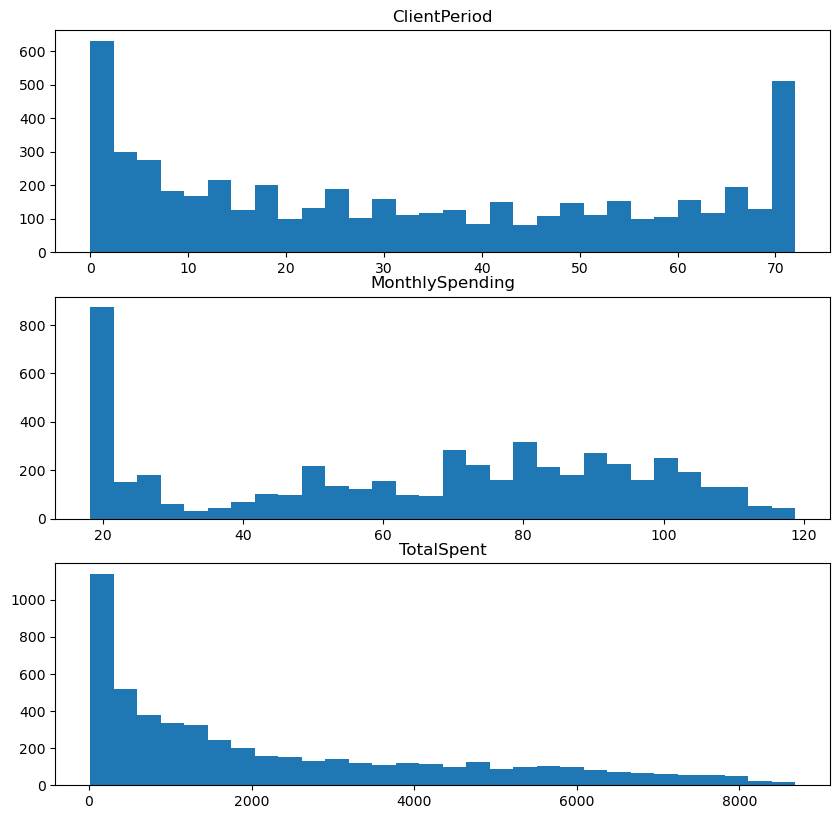

In [13]:
fig = plt.figure(figsize=(10, 10), dpi=100, facecolor='white')
for i, num_col in enumerate(num_cols):
    ax = fig.add_subplot(3, 1, i+1)
    ax.hist(data[num_col], bins=30)
    ax.set_title(num_col)


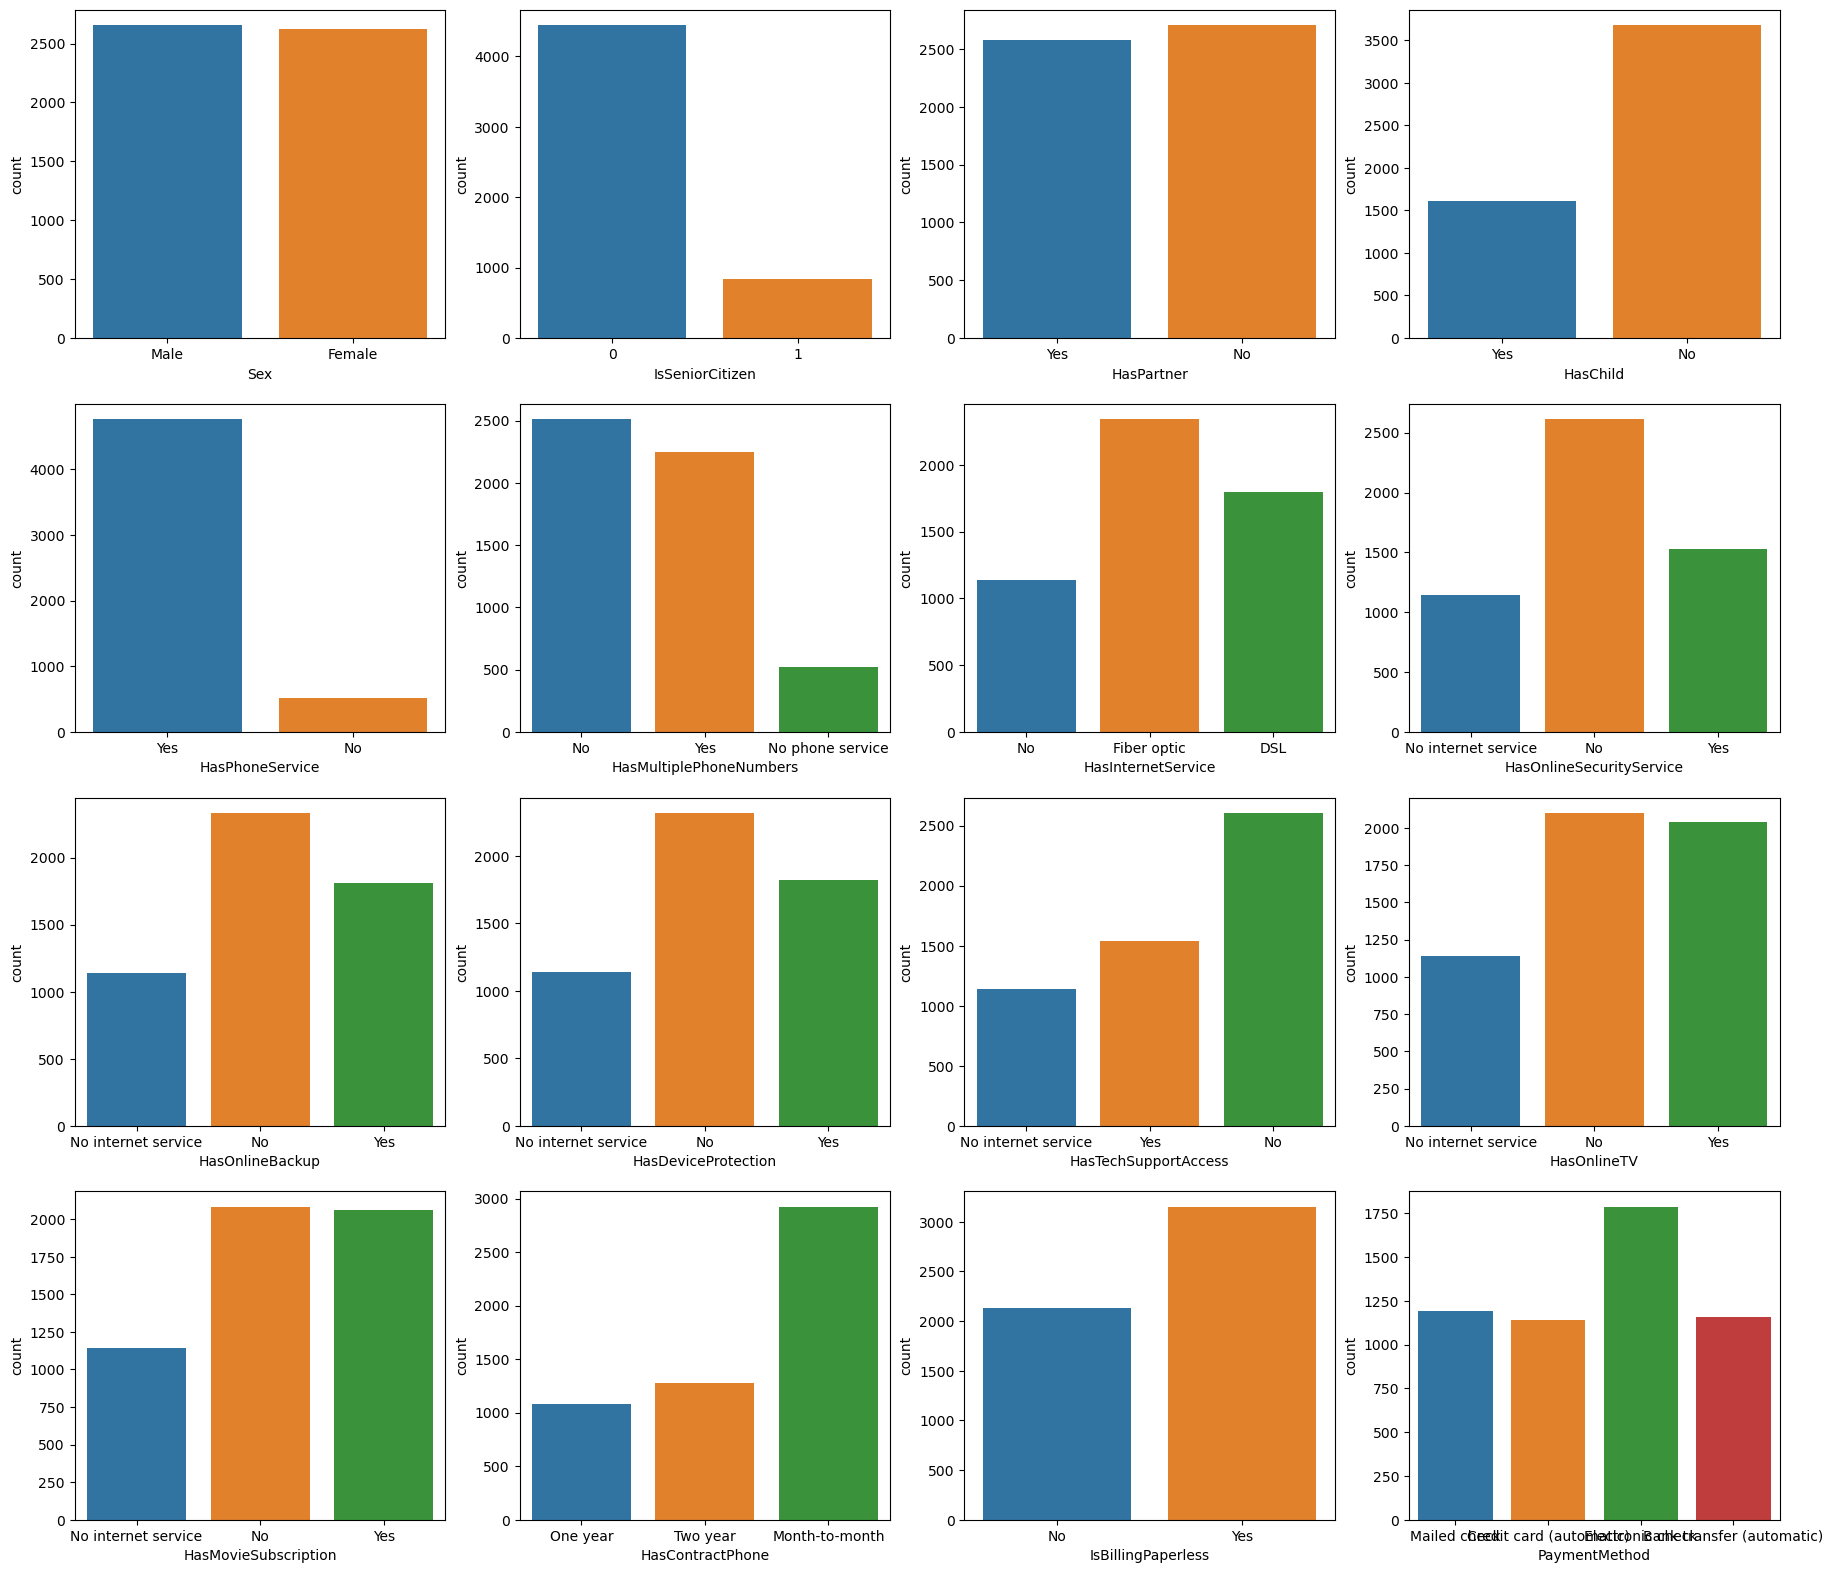

In [14]:
fig = plt.figure(figsize=(22, 20), dpi=100, facecolor='white')
for i, cat_col in enumerate(cat_cols):
    ax = fig.add_subplot(4, 4, i+1)
    sns.countplot(x = data[cat_col], ax=ax)
    

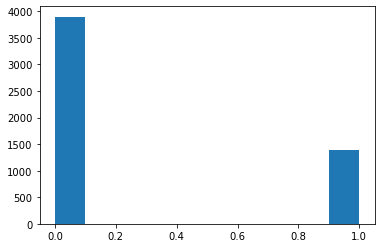

In [15]:
plt.hist(data['Churn'])
plt.show()

### Классы не сбалансированы

## Применение линейных моделей (3 балла)

1) Обработайте данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируйте числовые признаки, а категориальные закодируйте с помощью one-hot-encoding'а. 

2) С помощью кроссвалидации или разделения на train/valid выборку протестируйте разные значения гиперпараметра C и выберите лучший (можно тестировать С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC. 

Если вы разделяете на train/valid, то используйте LogisticRegressionCV. Он сам при вызове .fit() подберет параметр С. (не забудьте передать scroing='roc_auc', чтобы при кроссвалидации сравнивались значения этой метрики, и refit=True, чтобы при потом модель обучилась на всем датасете с лучшим параметром C). 


(более сложный вариант) Если вы будете использовать кроссвалидацию, то преобразования данных и LogisticRegression нужно соединить в один Pipeline с помощью make_pipeline, как это делалось во втором семинаре. Потом pipeline надо передать в GridSearchCV. Для one-hot-encoding'a можно испльзовать комбинацию LabelEncoder + OneHotEncoder (сначала превращаем строчки в числа, а потом числа првращаем в one-hot вектора.)

In [16]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline

In [17]:
X = data.drop('Churn', axis=1)
y = data['Churn']

scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])
X_cat = pd.get_dummies(X[cat_cols])
X = pd.concat([X[num_cols], X_cat], axis=1)

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [18]:
logreg = LogisticRegression()

logreg_gridsearch = GridSearchCV(logreg, {'C' : [100, 10, 1, 0.1, 0.01, 0.001]}, scoring='roc_auc', cv=5, n_jobs=8)

In [28]:
logreg = LogisticRegression(C=1)
logreg.fit(X_trainval, y_trainval)

LogisticRegression(C=1)

In [29]:
preds = logreg_gridsearch.predict_proba(X_test)[:,1]
score = roc_auc_score(y_test, preds)

Выпишите какое лучшее качество и с какими параметрами вам удалось получить

In [30]:
score

0.8251679438999827

## Применение градиентного бустинга (2 балла)

Если вы хотите получить баллы за точный ответ, то стоит попробовать градиентный бустинг. Часто градиентный бустинг с дефолтными параметрами даст вам 80% результата за 0% усилий.

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Разделите выборку на train/valid. Протестируйте catboost cо стандартными параметрами.

2) Протестируйте разные занчения параметроа количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию. 

(Дополнительно) Есть некоторые сложности с тем, чтобы использовать CatBoostClassifier вместе с GridSearchCV, поэтому мы не просим использовать кроссвалидацию. Но можете попробовать)

In [58]:
from catboost import CatBoostClassifier, Pool


X = data.drop('Churn', axis=1)
for col in X.select_dtypes(include=['object']):
    X[col] = X[col].astype('category')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)


In [103]:
catboost = CatBoostClassifier(cat_features=cat_cols, 
                                    task_type='GPU',
                                    verbose=False,
                                    eval_metric='AUC',
                                    #loss_function='AUC',
                                    devices='0:1')


search_spaces = {'iterations': Integer(10, 2000),
                 'depth': Integer(1, 8),
                 'min_data_in_leaf': Integer(1,5),
                 'boosting_type': Categorical(['Ordered', 'Plain']),
                 'learning_rate': Real(0.01, 1.0, 'log-uniform'),
                 'random_strength': Real(1e-9, 10, 'log-uniform'),
                 'bagging_temperature': Real(0.0, 1.0),
                 'border_count': Integer(1, 255),
                 'l2_leaf_reg': Integer(2, 30),
                 'scale_pos_weight':Real(0.01, 1.0, 'uniform')}

roc_auc = make_scorer(roc_auc_score, greater_is_better=True, needs_threshold=True)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

opt = BayesSearchCV(catboost,
                    search_spaces,
                    scoring=roc_auc,
                    cv=skf,
                    n_iter=100,
                    n_jobs=1,
                    return_train_score=False,
                    refit=False,
                    optimizer_kwargs={'base_estimator': 'GP'},
                    random_state=42)


overdone_control = DeltaYStopper(delta=0.0001)
time_limit_control = DeadlineStopper(total_time=60 * 60)


#catboost_grid.fit(Pool(X_train, y_train, cat_features=cat_cols))
#catboost.fit(Pool(X_train, y_train, cat_features))

In [104]:
def report_perf(optimizer, X, y, title, callbacks=None):
    """
    A wrapper for measuring time and performances of different optmizers
    
    optimizer = a sklearn or a skopt optimizer
    X = the training set 
    y = our target
    title = a string label for the experiment
    """
    start = time()
    if callbacks:
        optimizer.fit(X, y, callback=callbacks)
    else:
        optimizer.fit(X, y)
    d=pd.DataFrame(optimizer.cv_results_)
    best_score = optimizer.best_score_
    best_score_std = d.iloc[optimizer.best_index_].std_test_score
    best_params = optimizer.best_params_
    print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
           +u"\u00B1"+" %.3f") % (time() - start, 
                                  len(optimizer.cv_results_['params']),
                                  best_score,
                                  best_score_std))    
    print('Best parameters:')
    pprint.pprint(best_params)
    print()
    return best_params

In [105]:
best_params = report_perf(opt, X_train, y_train,'CatBoost', 
                          callbacks=[overdone_control, time_limit_control])

CatBoost took 3785.13 seconds,  candidates checked: 15, best CV score: 0.854 ± 0.011
Best parameters:
OrderedDict([('bagging_temperature', 0.44483251230115184),
             ('boosting_type', 'Plain'),
             ('border_count', 28),
             ('depth', 4),
             ('iterations', 384),
             ('l2_leaf_reg', 15),
             ('learning_rate', 0.020459551449165617),
             ('min_data_in_leaf', 4),
             ('random_strength', 0.00037445896306557123),
             ('scale_pos_weight', 0.9734749079159599)])



In [ ]:
# OrderedDict([('bagging_temperature', 0.44483251230115184),
#              ('boosting_type', 'Plain'),
#              ('border_count', 28),
#              ('depth', 4),
#              ('iterations', 384),
#              ('l2_leaf_reg', 15),
#              ('learning_rate', 0.020459551449165617),
#              ('min_data_in_leaf', 4),
#              ('random_strength', 0.00037445896306557123),
#              ('scale_pos_weight', 0.9734749079159599)])

In [107]:
catboost_best_params = CatBoostClassifier(cat_features=cat_cols, 
                                    task_type='GPU',
                                    verbose=30,
                                    eval_metric='AUC', devices='0',
                                    **best_params)

catboost_best_params.fit(X_train, y_train)

0:	learn: 0.8332872	total: 35.4ms	remaining: 13.6s
1:	learn: 0.8364055	total: 63.8ms	remaining: 12.2s
2:	learn: 0.8366190	total: 90.8ms	remaining: 11.5s
3:	learn: 0.8394839	total: 114ms	remaining: 10.9s
4:	learn: 0.8397493	total: 138ms	remaining: 10.5s
5:	learn: 0.8413174	total: 162ms	remaining: 10.2s
6:	learn: 0.8410224	total: 186ms	remaining: 10s
7:	learn: 0.8433805	total: 210ms	remaining: 9.86s
8:	learn: 0.8436912	total: 249ms	remaining: 10.4s
9:	learn: 0.8444049	total: 278ms	remaining: 10.4s
10:	learn: 0.8448919	total: 308ms	remaining: 10.4s
11:	learn: 0.8446453	total: 337ms	remaining: 10.5s
12:	learn: 0.8456728	total: 367ms	remaining: 10.5s
13:	learn: 0.8457184	total: 396ms	remaining: 10.5s
14:	learn: 0.8460812	total: 426ms	remaining: 10.5s
15:	learn: 0.8460082	total: 454ms	remaining: 10.4s
16:	learn: 0.8481797	total: 483ms	remaining: 10.4s
17:	learn: 0.8482577	total: 537ms	remaining: 10.9s
18:	learn: 0.8490081	total: 590ms	remaining: 11.3s
19:	learn: 0.8490605	total: 644ms	remain

In [109]:
preds = catboost_best_params.predict_proba(X_test)[:,1]
score = roc_auc_score(y_test, preds)

Выпишите какое лучшее качество и с какими параметрами вам удалось получить

In [110]:
score

0.8304058286051138

# Предсказания

In [ ]:
X_sub = test
submission = pd.read_csv('./submission.csv')

submission['Churn'] = catboost_best_params.predict_proba(X_sub)[:,1]
submission.to_csv('./my_submission.csv', index=False)

# Kaggle (5 баллов)

Как выставить баллы:

1) 1 >= roc auc > 0.84 это 5 баллов

2) 0.84 >= roc auc > 0.7 это 3 балла

3) 0.7 >= roc auc > 0.6 это 1 балл

4) 0.6 >= roc auc это 0 баллов


Для выполнения задания необходимо выполнить следующие шаги.
* Зарегистрироваться на платформе [kaggle.com](kaggle.com). Процесс выставления оценок будет проходить при подведении итогового рейтинга. Пожалуйста, укажите во вкладке Team -> Team name свои имя и фамилию в формате Имя_Фамилия (важно, чтобы имя и фамилия совпадали с данными на Stepik).
* Обучить модель, получить файл с ответами в формате .csv и сдать его в конкурс. Пробуйте и экспериментируйте. Обратите внимание, что вы можете выполнять до 20 попыток сдачи на kaggle в день.
* После окончания соревнования отправить в итоговый ноутбук с решением на степик. 
* После дедлайна проверьте посылки других участников по критериям. Для этого надо зайти на степик, скачать их ноутбук и проверить скор в соревновании.

# Danis_Zaripov Score: 0.85272